In [1]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [2]:
import os

# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

# Standard Library imports
import json
import math

# Third-party imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
from keras import losses, ops, optimizers, metrics
from keras.optimizers import schedules
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import KFold
import keras_hub


In [3]:
# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5
EPOCHS = 50
GAMMA = 2.0


In [4]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 734kB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 2.95MB/s]


100%|██████████| 98.1M/98.1M [00:03<00:00, 31.5MB/s]


100%|██████████| 90.2M/90.2M [00:03<00:00, 30.4MB/s]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the learning rate schedule

In [6]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [7]:
total_images = 336
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

# Load Dataset and Show

In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Ensure images are in the correct format for display
    images = images.numpy()  # Convert tensor to NumPy array

    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot each image individually
            ax.imshow(images[i])  # Display each image
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=10)
        else:
            ax.axis("off")  # Turn off axis if there are more subplots than images

    plt.tight_layout()
    plt.show()

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

Found 336 files belonging to 4 classes.


# preprocessing

In [ ]:
# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define the gamma transformation function
def apply_gamma(image, gamma=1.0):
    # Apply gamma correction by adjusting pixel values
    gamma_corrected = tf.image.adjust_gamma(image, gamma=gamma)
    return gamma_corrected

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
gamma_value = 1.5  # Define the gamma value to apply (adjust as needed)

for image, label in dataset:
    # Add the original image
    images.append(image[0])  # Remove the extra batch dimension
    labels.append(label[0])  # Remove the extra batch dimension for label

    # Apply gamma transformation and add the transformed image
    gamma_transformed_image = tf.image.adjust_gamma(image[0], gamma=gamma_value)
    images.append(gamma_transformed_image)
    labels.append(label[0])  # Same label for the gamma-transformed image

# Convert lists to numpy arrays for KFold processing
images = np.array([img.numpy() for img in images])  # Convert each tensor to a NumPy array
labels = np.array([lbl.numpy() for lbl in labels])

# Check the shape to confirm
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 336 files belonging to 4 classes.
Images shape: (672, 224, 224, 3)
Labels shape: (672,)


# KFold

In [27]:
from sklearn.model_selection import StratifiedKFold


kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=43)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0
best_weights = None

train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images, labels):
    print(f"\nTraining fold {fold_no}...")

    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    # train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    # val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
        metrics=["accuracy"]
    )


    history = model.fit(train_dataset, epochs=12, validation_data=val_dataset)


    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])


    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()

    fold_no += 1



Training fold 1...
Epoch 1/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.1752 - loss: 1.3927 - val_accuracy: 0.3185 - val_loss: 1.3666
Epoch 2/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.4302 - loss: 1.3428 - val_accuracy: 0.4519 - val_loss: 1.2915
Epoch 3/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.4469 - loss: 1.2577 - val_accuracy: 0.4519 - val_loss: 1.2723
Epoch 4/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.4469 - loss: 1.2359 - val_accuracy: 0.4519 - val_loss: 1.2231
Epoch 5/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.4469 - loss: 1.1564 - val_accuracy: 0.4519 - val_loss: 1.0789
Epoch 6/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.4469 - loss: 1.0604 - val_accuracy: 0.4519 - val_loss: 0.9765
Epoch 7/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.5158 - loss: 0.9225 - val_accuracy: 0.5778 - val_loss: 0.8574
Epoch 8/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7346 - loss: 0.7459

In [28]:
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

Plot training and validation accuracy for each fold

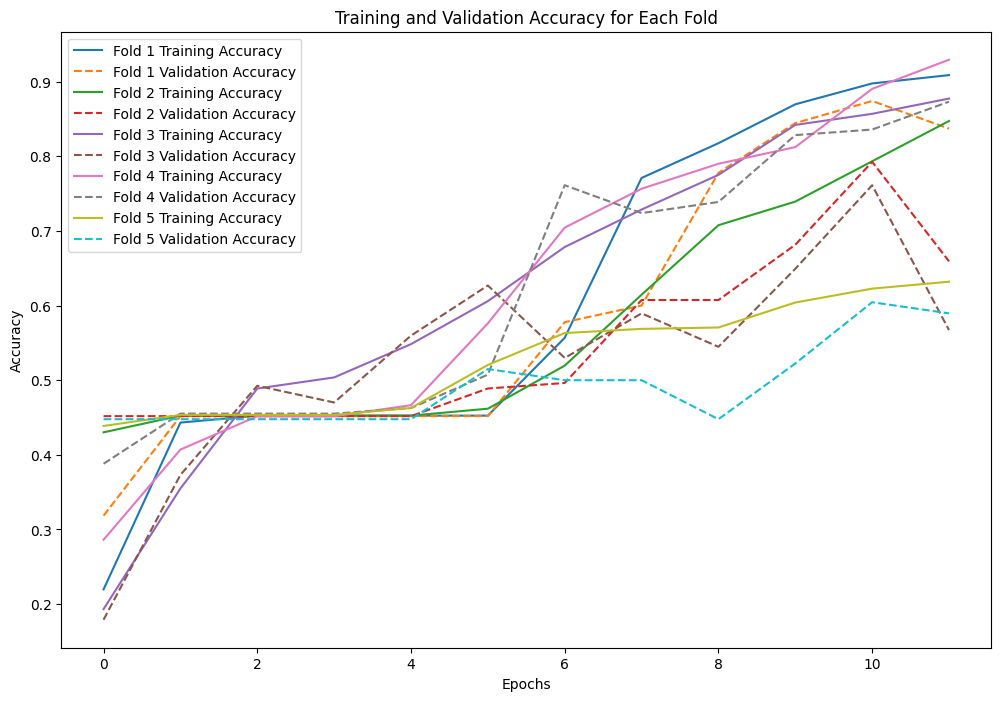

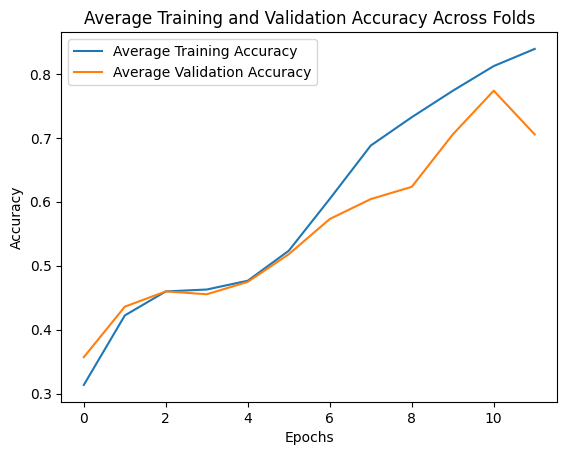

In [29]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final Model

In [30]:
final_model = keras.Model(inputs=inputs, outputs=outputs)
final_model.set_weights(best_weights)


final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    metrics=["accuracy"]
)

full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

history = final_model.fit(full_train_dataset, epochs=15)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 835ms/step - accuracy: 0.9053 - loss: 0.2778
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.9245 - loss: 0.2326
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9539 - loss: 0.1723
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.9725 - loss: 0.1425
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9799 - loss: 0.1061
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.9946 - loss: 0.0719
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.9948 - loss: 0.0494
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9967 - loss: 0.0435
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 1.0000 - loss: 0.0268
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 1.0000 - loss: 0.0204
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 1.0000 - loss: 0.0138
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/st

# Plot training accuracy and loss for the final model


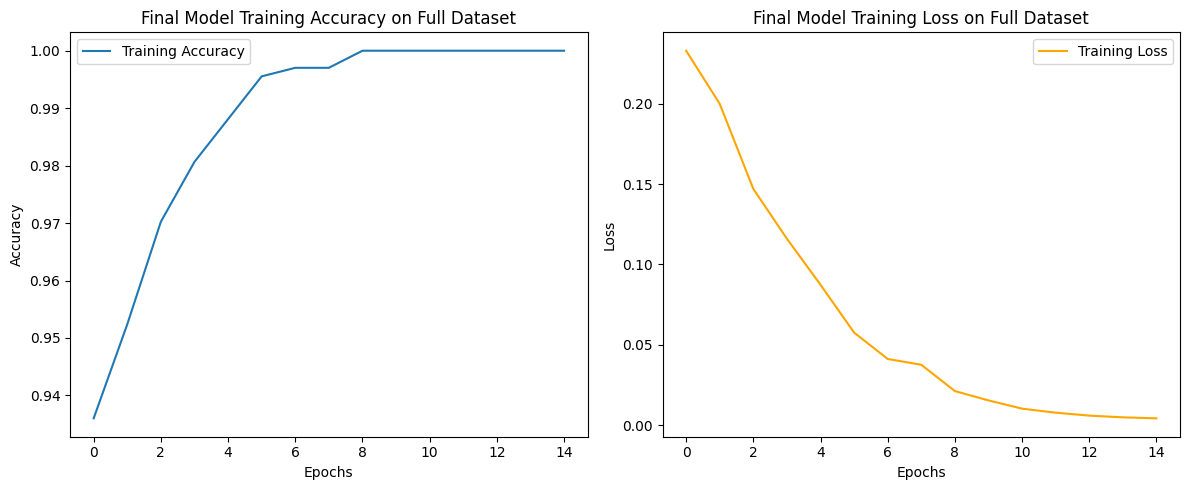

In [31]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load the test dataset from directory


In [32]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

 # Apply gamma and normalize

# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 55 files belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8614 - loss: 1.0301

Test Loss: 1.1123636960983276
Test Accuracy: 0.8545454144477844


Found 55 files belonging to 4 classes.
Class names: ['KO', 'OK', 'RzKO', 'RzOK']
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.8509 - loss: 1.1111

Test Loss: 1.1123638153076172
Test Accuracy: 0.8545454144477844
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 800x800 with 0 Axes>

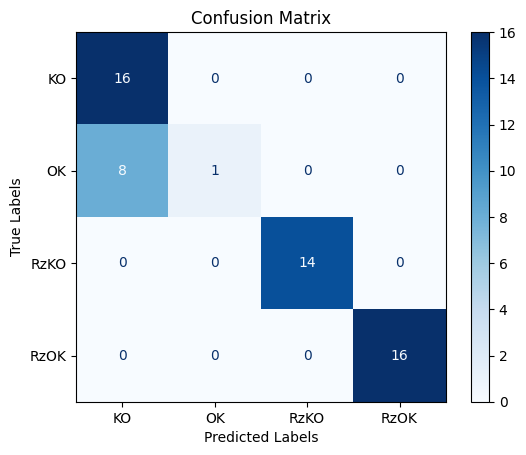

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

# Retrieve class names from the dataset
class_names = test_dataset.class_names
print("Class names:", class_names)


# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions and true labels for the test dataset
y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)



# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define the gamma transformation function
def apply_gamma(image, gamma=1.0):
    # Apply gamma correction by adjusting pixel values
    gamma_corrected = tf.image.adjust_gamma(image, gamma=gamma)
    return gamma_corrected

Found 336 files belonging to 4 classes.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def apply_histogram_equalization(image):
    # Convert to grayscale if needed, or apply to each channel separately for color images
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Apply histogram equalization to each channel
        equalized_image = np.zeros_like(image)
        for i in range(3):  # Apply to each color channel
            equalized_image[:, :, i] = cv2.equalizeHist(image[:, :, i])
        return equalized_image
    else:
        # For grayscale images
        return cv2.equalizeHist(image)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0  # Track the best validation accuracy
best_weights = None    # Placeholder for best model weights

train_accuracy_history = []
val_accuracy_history = []

# StratifiedKFold requires both features and labels to split
for train_index, val_index in kf.split(images, labels):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets with gamma transformation applied
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Normalize after gamma
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Normalize after gammab
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using the Functional API
    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )

    # Train the model on this fold
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

    # Append accuracy histories for each fold
    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])

    # Get the validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    # Check if this fold's model is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()  # Save the weights of the best model

    fold_no += 1



Training fold 1...
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.2999 - loss: 1.3711 - val_accuracy: 0.4559 - val_loss: 1.3500
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.4346 - loss: 1.3445 - val_accuracy: 0.4559 - val_loss: 1.3324
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.4014 - loss: 1.3248 - val_accuracy: 0.4559 - val_loss: 1.2943
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.4014 - loss: 1.3047 - val_accuracy: 0.4559 - val_loss: 1.2604
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.4102 - loss: 1.2927 - val_accuracy: 0.4559 - val_loss: 1.2567
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.4014 - loss: 1.2803 - val_accuracy: 0.4559 - val_loss: 1.2358
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.4014 - loss: 1.2609 - val_accuracy: 0.4559 - val_loss: 1.2306
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.4014 - loss: 1.2445 - val_accuracy:

In [ ]:
# Convert lists to numpy arrays for easier averaging
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

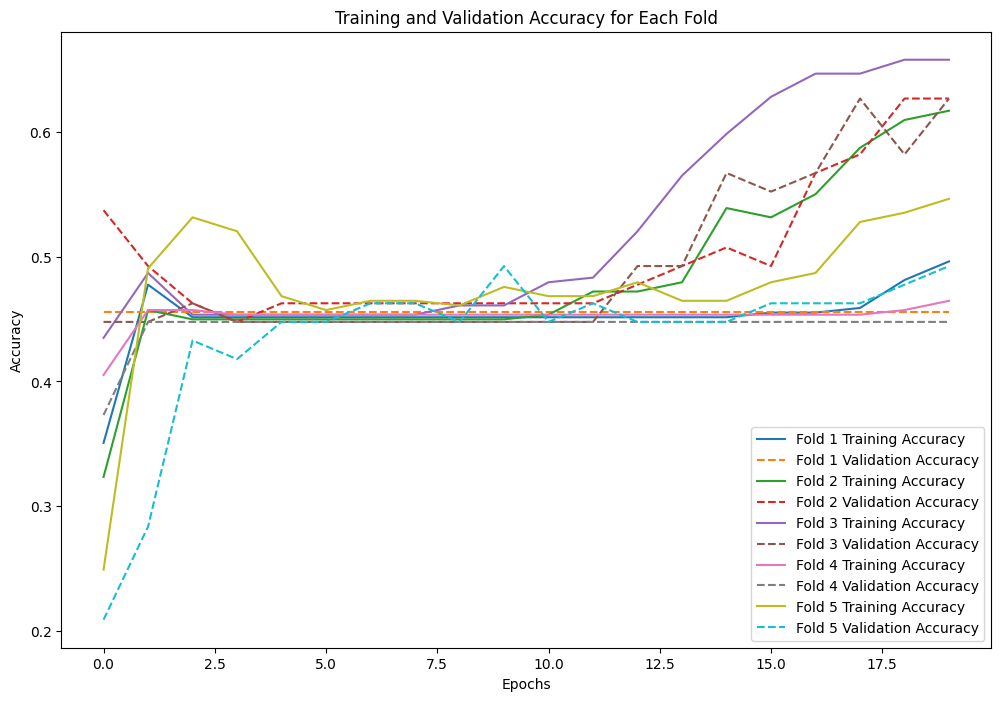

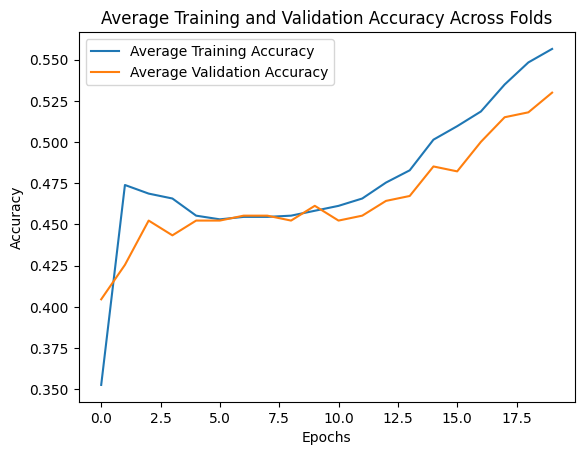

In [ ]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# After cross-validation, create a new model and load the best weights
final_model = keras.Model(inputs=inputs, outputs=outputs)  # Same architecture as before
final_model.set_weights(best_weights)  # Load best weights from cross-validation

# Compile the final model
final_model.compile(
    loss="sparse_categorical_crossentropy",
    # optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

# Combine the full dataset for fine-tuning
full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.map(lambda x, y: (x / 255.0, y))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Fine-tune the model on the full dataset
history =  final_model.fit(full_train_dataset, epochs=10)

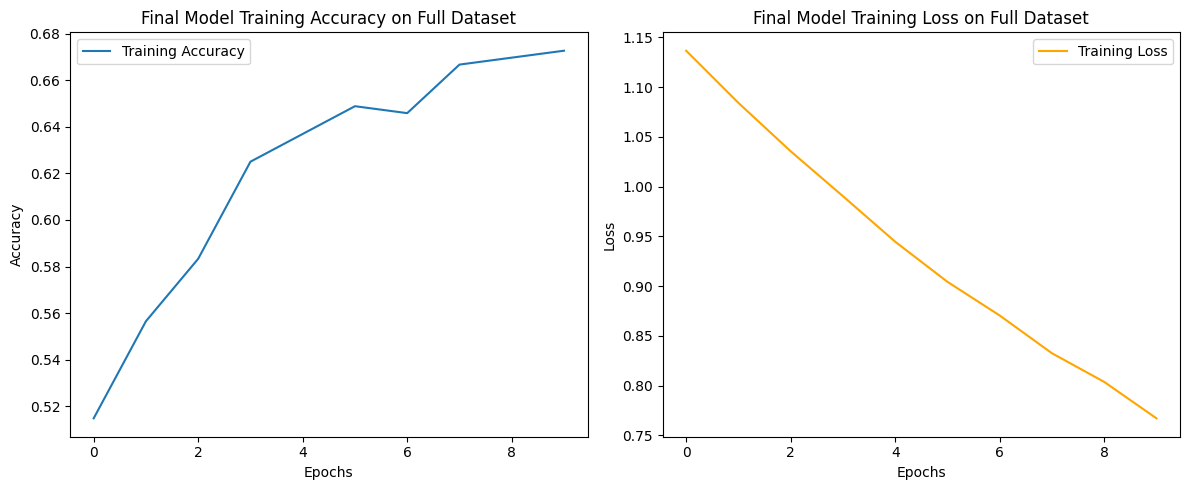

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
  test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE,
      label_mode='int'  # Use 'int' labels to match the training dataset
  )

  # Apply gamma transformation and normalize the test dataset
  test_dataset = test_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Apply gamma and normalize

  # Evaluate the final model on the test dataset
  test_loss, test_accuracy = final_model.evaluate(test_dataset)
  print(f"\nTest Loss: {test_loss}")
  print(f"Test Accuracy: {test_accuracy}")